<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/10-attention-mechanisms/01_attention_mechanisms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Attention mechanisms

Deep learning models can also learn to pay attention to some input, or features, and
ignore other features. They do this with attention mechanisms, which are another type of
prior belief we can impose on our network. 

Attention mechanisms help us deal with
situations where part of our input may be irrelevant, or when we need to focus on one
feature of many features being fed into the model.

We would like to endow our networks with the ability to ignore superfluous and
distracting inputs to focus on the most important portions, and that’s the goal of
an attention mechanism. 

If you believe some of your input features are more or less
important than other features, you should consider using an attention-based approach
in your model. 

If you want state-of-the-art results on speech recognition, object detection,
a chat bot, or machine translation, for instance, you will probably be using an attention
mechanism.

In this notebook, we see how attention works on some toy problems out of the MNIST dataset that is too hard for a normal network but is easily and better
solved with a simple kind of attention that learns how to score the importance of each
item in the input. 

Then we improve the simple attention into a full-fledged approach
that takes into account some context to better infer the importance of items in the input.

##Setup

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import train_network, Flatten, weight_reset, View, set_seed

In [3]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [4]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##Dataset

Now that we can load the dataset.

In [ ]:
# let’s quickly load MNIST dataset
mnist_train = torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)

Attention mechanisms are most useful when we have multiple items as inputs into our model.

Since MNIST is a single digit, we will augment each item in MNIST to become a
bag of digits. We use fully connected layers for this (i.e., flattened MNIST, ignoring the
image nature), so instead of having a batch of digits `(B,D)`, we have `T` digits `(B, T, D)`.

So why did I call this a bag instead of a sequence? 

Because we don’t care in what order
the digits are presented in the tensor. We just need a tensor large enough to hold everything in the bag.

Given a bag of digits $x_1, x_2, ... , x_T$ , we have a label y that is equal to the largest digit in the bag. If our bag contains 0, 2, 9, the label for the bag is “9.”

Let's implements a LargestDigit class to wrap an input dataset and create new items by
randomly filling a bag of toSample items and selecting the maximum label value.

In [7]:
class LargestDigit(Dataset):
  """
  Creates a modified version of a dataset where some number of samples are taken, 
  and the true label is the largest label sampled. When used with MNIST the labels 
  correspond to their values (e.g., digit "6" has label 6)
  """
  def __init__(self, dataset, toSample=3):
    """
    dataset: the dataset to sample from
    toSample: the number of items from the dataset to sample
    """
    self.dataset = dataset
    self.toSample = toSample 

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    # Randomly select n=self.toSample items from the dataset
    selected = np.random.randint(0, len(self.dataset), size=self.toSample)
    
    # Stack the n items of shape (B, *) shape into (B, n, *)
    x_new = torch.stack([self.dataset[i][0] for i in selected])
    # Label is the maximum label
    y_new = max([self.dataset[i][1] for i in selected])
    
    # Return (data, label) pair!
    return x_new, y_new

In [8]:
B = 128
epochs= 10

largest_train = LargestDigit(mnist_train)
largest_test = LargestDigit(mnist_test)

train_loader = DataLoader(largest_train, batch_size=B, shuffle=True)
test_loader = DataLoader(largest_train, batch_size=B)

True Label is = 8


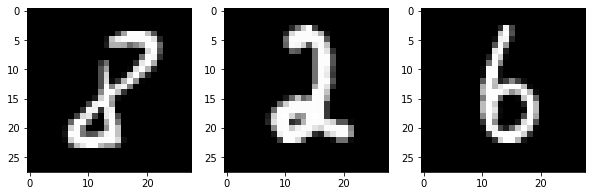

In [9]:
# Want a consistent dataset split
set_seed(34)

x, y = largest_train[0]

f, axarr = plt.subplots(1, 3, figsize=(10, 10))
for i in range(3):
  axarr[i].imshow(x[i, 0, :].numpy(), cmap="gray", vmin=0, vmax=1)
print(f"True Label is = {y}")

##Baseline Model

Let's train a simple fully connected network and treat
this like any other classification problem we might attempt. 

This will be our baseline
and show how hard the new version of MNIST is:.

In [10]:
neurons = 256     
classes = 10 

In [11]:
simple_net = nn.Sequential(
  nn.Flatten(),
  nn.Linear(784 * 3, neurons), # 784*3 because there are 784 pixels in an image and 3 images in the bag
  nn.LeakyReLU(),
  nn.BatchNorm1d(neurons),

  nn.Linear(neurons, neurons),
  nn.LeakyReLU(),
  nn.BatchNorm1d(neurons),

  nn.Linear(neurons, neurons),
  nn.LeakyReLU(),
  nn.BatchNorm1d(neurons),

  nn.Linear(neurons, classes)
)

Let's train this model.

In [ ]:
simple_results = train_network(simple_net, 
                               nn.CrossEntropyLoss(), 
                               train_loader, 
                               val_loader=test_loader,
                               epochs=epochs,
                               score_funcs={"Accuracy": accuracy_score},
                               device=device)

Now let’s plot the results.

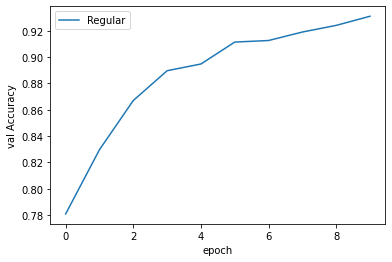

In [13]:
sns.lineplot(x="epoch", y="val Accuracy", data=simple_results, label="Regular")

##Attention mechanics

We need a new version of the nn.Flatten
function that leaves the first two axes of our tensor alone.

In [14]:
class FlattenLayer(nn.Module):
  """
  Takes a vector of shape (A, B, C, D, E, ...)
  and flattens everything but the first two dimensions, 
  giving a result of shape (A, B, C*D*E*...)
  """
  def forward(self, input):
    return input.view(input.size(0), input.size(1), -1)

Let's create a Combiner class that will combine the attention weights $\alpha$ with the extracted feature representations $h_1,h_2,..., h_T$ and computes the weighted average $\bar x = \Sigma_{i=1}^T \alpha_i.h_i$

In [15]:
class Combiner(nn.Module):
  """
  This class is used to combine a feature exraction network F and a importance prediction network W,
  and combine their outputs by adding and summing them together. 
  """
  def __init__(self, feature_extraction, weight_selection):
    """
    featureExtraction: a network that takes an input of shape (B, T, D) and outputs a new representation of shape (B, T, D'). 
    weightSelection: a network that takes in an input of shape (B, T, D') and outputs a 
      tensor of shape (B, T, 1) or (B, T). It should be normalized, so that the T values at the end sum to one (torch.sum(_, dim=1) = 1.0)
    """
    super(Combiner, self).__init__()
    self.feature_extraction = feature_extraction
    self.weight_selection = weight_selection

  def forward(self, input):
    """
    input: a tensor of shape (B, T, D)
    return: a new tensor of shape (B, D')
    """
    features = self.feature_extraction(input)  # (B, T, D) h_i = F(x_i)
    weights = self.weight_selection(features)  # (B, T) or (B, T, 1) for alpha
    if len(weights.shape) == 2:                # (B, T) shape
      weights.unsqueese(2)                     # Now (B, T, 1) shape
    
    result = features * weights                # (B, T, D) computes alpha_i . h_i
    return torch.sum(result, dim=1)            # Sums over the T dimension, giving the (B, D) final shape

Now we are ready to define our attention-based model for this problem.

In [16]:
T = 3   # how many items are in our bag
D = 784 # how many number of features

In [17]:
# let's define is the feature extraction network
backbone_network = nn.Sequential(
    FlattenLayer(),         # Shape is now (B, T, D)
    nn.Linear(D, neurons),  # Shape becomes (B, T, neurons)
    nn.LeakyReLU(),
    nn.Linear(neurons, neurons),
    nn.LeakyReLU(),
    nn.Linear(neurons, neurons),
    nn.LeakyReLU()          # still (B, T, neurons) on the way out
) 

Now we need a network to compute the attention mechanism weights $\alpha$.

In [18]:
attention_mechanism = nn.Sequential(
    # Shape is (B, T, neurons)
    nn.Linear(neurons, neurons),
    nn.LeakyReLU(),
    nn.Linear(neurons, 1),  # (B, T, 1)
    nn.Softmax(dim=1)
)

Now we can now define a complete attention-based network.

In [ ]:
simple_attention_net = nn.Sequential(
    # input is (B, T, C, W, H). backbone & attention will be used by combiner to process
    Combiner(backbone_network, attention_mechanism),  # result is (B, neurons)
    nn.BatchNorm1d(neurons),
    nn.Linear(neurons, neurons),
    nn.LeakyReLU(),
    nn.BatchNorm1d(neurons),
    nn.Linear(neurons, classes)
)

# let's train it
simple_attn_results = train_network(simple_attention_net, 
                                    nn.CrossEntropyLoss(), 
                                    train_loader, 
                                    val_loader=test_loader,
                                    epochs=epochs,
                                    score_funcs={"Accuracy": accuracy_score},
                                    device=device)

Now let’s plot the results.

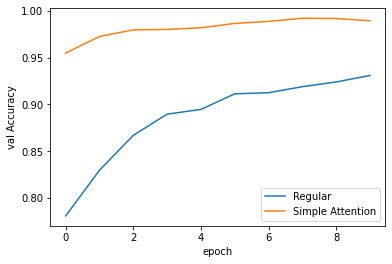

In [20]:
sns.lineplot(x="epoch", y="val Accuracy", data=simple_results, label="Regular")
sns.lineplot(x="epoch", y="val Accuracy", data=simple_attn_results, label="Simple Attention")

We can also select random samples from the dataset and look at how the attention
mechanism selects the inputs.

True Label is = 9


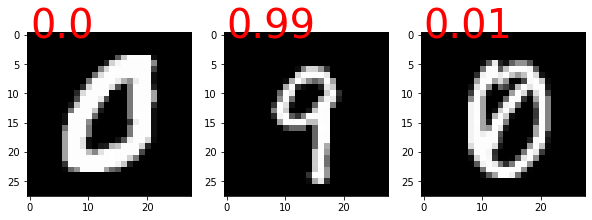

In [21]:
set_seed(1)

# Select a data point (which is a bag)
x, y = largest_train[0]
x = x.to(device)

with torch.no_grad():
  weights = attention_mechanism(backbone_network(x.unsqueeze(0)))  # apply score(F(x))
  weights = weights.cpu().numpy().ravel()

# make a plot for all 3 digits
f, axarr = plt.subplots(1, 3, figsize=(10, 10))
for i in range(3):
  # Plot the digit
  axarr[i].imshow(x[i, 0, :].cpu().numpy(), cmap="gray", vmin=0, vmax=1)
  # Draw the attention score in the top left
  axarr[i].text(0.0, 0.5, str(round(weights[i], 2)), dict(size=40, color="red"))

print(f"True Label is = {y}")

We have now seen how this simple attention can help us learn faster and better networks
when only a subset of the inputs is important.



## Attention with context

The attention mechanism uses global information to make local decisions.
The local decisions came in the form of the weights $\alpha$, and the context provides the global information.

There are three common ways to compute the score from the representation $h$ and the context $\bar h$, commonly called:

* Dot score
* General score
* Additive score

###Dot score

We take the dot product because it measures how aligned
in direction and size two vectors are.

$$score(h_t, \bar h) = \frac{h_t^T \bar h}{\sqrt{H}} $$

To avoid large values, we devide it by $\sqrt{H}$.

In [22]:
class DotScore(nn.Module):
  def __init__(self, H):
    """
    H: the number of dimensions coming into the dot score
    """
    super(DotScore, self).__init__()
    self.H = H

  def forward(self, states, context):
    """
    states: (B, T, H) shape
    context: (B, H) shape
    output: (B, T, 1), giving a score to each of the T items based on the context
    """
    T = states.size(1)
    scores = torch.bmm(states, context.unsqueeze(2)) / np.sqrt(self.H) # (B, T, H) -> (B, T, 1)
    return scores

###General score

Instead of simply computing the dot product between each item $h_t$ with
the context $\bar h$ , we add a matrix $W$ in between them.

$$score(h_t, \bar h) = h_t^TW \bar h $$

This implementation is simple because the general score has what is called a
bilinear relationship.

In [23]:
class GeneralScore(nn.Module):
  def __init__(self, H):
    """
    H: the number of dimensions coming into the GeneralScore score
    """
    super(GeneralScore, self).__init__()
    self.H = H
    self.W = nn.Bilinear(H, H, 1)

  def forward(self, states, context):
    """
    states: (B, T, H) shape
    context: (B, H) shape
    output: (B, T, 1), giving a score to each of the T items based on the context
    """
    T = states.size(1)
    # Repeating the values T times 
    context = torch.stack([context for _ in range(T)], dim=1)  # (B, H) -> (B, T, H)
    scores = self.W(states, context)  # (B, T, H) -> (B, T, 1)
    return scores

###Additive attention

The idea behind the additive layer is fairly simple: let a small neural network figure
out the weighting for us.

In [24]:
class AdditiveAttentionScore(nn.Module):
  def __init__(self, H):
    """
    H: the number of dimensions coming into the AdditiveAttentionScore
    """
    super(AdditiveAttentionScore, self).__init__()
    self.v = nn.Linear(H, 1)
    self.W = nn.Linear(2 * H, H)  # 2*H because we are going to concatenate two inputs

  def forward(self, states, context):
    """
    states: (B, T, H) shape
    context: (B, H) shape
    output: (B, T, 1), giving a score to each of the T items based on the context
    """
    T = states.size(1)
    # Repeating the values T times 
    context = torch.stack([context for _ in range(T)], dim=1)  # (B, H) -> (B, T, H)
    state_context_combined = torch.cat((states, context), dim=2)  # (B, T, H) + (B, T, H)  -> (B, T, 2*H)
    scores = self.v(torch.tanh(self.W(state_context_combined)))  # (B, T, H) -> (B, T, 1)
    return scores 

##Computing attention weights

Now that we have the various attention scores we want, we’ll define a simple helper Module that takes in the raw scores $\alpha$ and extracted representations $h...$ and computes
the final output $\bar x$. 

This will replace our Combiner module by adding one new step:
applying a mask to the inputs.

In [25]:
class ApplyAttention(nn.Module):
  """This helper module is used to apply the results of an attention mechanism to a set of inputs. """
  def __init__(self):
    super(ApplyAttention, self).__init__()

  def forward(self, states, attention_scores, mask=None):
    """
    states: (B, T, H) shape giving the T different possible inputs
    attention_scores: (B, T, 1) score for each item at each context
    mask: None if all items are present. Else a boolean tensor of shape 
        (B, T), with `True` indicating which items are present / valid. 
        
    returns: a tuple with two tensors. The first tensor is the final context
    from applying the attention to the states (B, H) shape. The second tensor
    is the weights for each state with shape (B, T, 1).
    """
    if mask is not None:
      # set everything not present to a large negative value that will cause vanishing gradients 
      attention_scores[~mask] = -1000.0
    # compute the weight for each score
    weights = F.softmax(attention_scores, dim=1)  # (B, T, 1) still, but sum(T) = 1
    final_context = (states * weights).sum(dim=1) # (B, T, D) * (B, T, 1) -> (B, D)
    return final_context, weights

In [26]:
def get_mask_by_fill(x, time_dimension=1, fill=0):
  """
  x: the original input with three or more dimensions, (B, ..., T, ...)
      which may have unsued items in the tensor. B is the batch size, and T is the time dimension. 
  time_dimension: the axis in the tensor `x` that denotes the time dimension
  fill: the constant used to denote that an item in the tensor is not in use, and should be masked out (`False` in the mask). 
  
  return: A boolean tensor of shape (B, T), where `True` indicates the value at that time is good to use, and `False` that it is not.
  """
  # skip the first dimension 0 because that is the batch dimension
  to_sum_over = list(range(1, len(x.shape)))

  if time_dimension in to_sum_over:
    to_sum_over.remove(time_dimension)
  
  with torch.no_grad():
    """
    (x!=fill) determines locations that might be unused, beause they are missing the fill value we are looking for to indicate lack of use. 
    We then count the number of non-fill values over everything in that time slot (reducing changes the shape to (B, T)). If any one entry 
    is non equal to this value, the item represent must be in use - so return a value of true.
    """
    mask = torch.sum((x != fill), dim=to_sum_over) > 0
  return mask 

Let’s see a quick example of how this new function works.

In [27]:
# creates the hypothetical data and computes the appropriate mask
with torch.no_grad():
  x = torch.rand((5, 3, 1, 7, 7))
  x[0, -1, :] = 0   # Don't use the last item in the first input
  x[3, :] = 0       # Don't use any of the 4'th item!
  x[4, 0, 0, 0] = 0 # Make it _look_ like we aren't using part of the 5th, but we still are!
  # This last line was added to show that this works even on tricky inputs
  mask = get_mask_by_fill(x)
  
print(mask)

tensor([[ True,  True, False],
        [ True,  True,  True],
        [ True,  True,  True],
        [False, False, False],
        [ True,  True,  True]])


##Putting it all together

Now let's create a complete attention mechanism with context.

Let’s define a SmarterAttentionNet that is our entire network.

In [28]:
class SmarterAttentionNet(nn.Module):

  def __init__(self, input_size, hidden_size, output_size, score_net=None):
    super(SmarterAttentionNet, self).__init__()

    self.backbone = nn.Sequential(
      FlattenLayer(),                     # Shape is now (B, T, D)
      nn.Linear(input_size, hidden_size), # Shape becomes (B, T, H)
      nn.LeakyReLU(),
      nn.Linear(hidden_size, hidden_size),
      nn.LeakyReLU(),
      nn.Linear(hidden_size, hidden_size),
      nn.LeakyReLU(),                    # returns (B, T, H)
    )

    # Try changing this and see how the results change!
    self.score_net = AdditiveAttentionScore(hidden_size) if (score_net is None) else score_net

    self.apply_attention = ApplyAttention()

    self.prediction_net = nn.Sequential(
      nn.BatchNorm1d(hidden_size),         # (B, H)
      nn.Linear(hidden_size, hidden_size),
      nn.LeakyReLU(),
      nn.BatchNorm1d(hidden_size),
      nn.Linear(hidden_size, output_size)  # (B, H)
    )

  def forward(self, input_x):
    mask = get_mask_by_fill(input_x)

    h = self.backbone(input_x)  # (B, T, D) -> (B, T, H)

    # computes torch.mean but ignoring the masked out parts first add together all the valid items
    #h_context = torch.mean(h, dim=1)
    h_context = (mask.unsqueeze(-1) * h).sum(dim=1)  # (B, T, H) -> (B, H)
    # then divide by the number of valid items, pluss a small value incase a bag was all empty
    h_context = h_context / (mask.sum(dim=1).unsqueeze(-1) + 1e-10)

    scores = self.score_net(h, h_context)      # (B, T, H) , (B, H) -> (B, T, 1)
    final_context, _ = self.apply_attention(h, scores, mask=mask)
    return self.prediction_net(final_context)  # (B, H) -> (B, classes)

Let’s train up some better attention models.

In [29]:
attention_dot = SmarterAttentionNet(D, neurons, classes, score_net=DotScore(neurons))
attention_general = SmarterAttentionNet(D, neurons, classes, score_net=GeneralScore(neurons))
attention_additive = SmarterAttentionNet(D, neurons, classes, score_net=AdditiveAttentionScore(neurons))

In [ ]:
attention_dot_results = train_network(attention_dot, 
                                    nn.CrossEntropyLoss(), 
                                    train_loader, 
                                    val_loader=test_loader,
                                    epochs=epochs,
                                    score_funcs={"Accuracy": accuracy_score},
                                    device=device)

In [ ]:
attention_general_results = train_network(attention_general, 
                                    nn.CrossEntropyLoss(), 
                                    train_loader, 
                                    val_loader=test_loader,
                                    epochs=epochs,
                                    score_funcs={"Accuracy": accuracy_score},
                                    device=device)

In [ ]:
attention_additive_results = train_network(attention_additive, 
                                    nn.CrossEntropyLoss(), 
                                    train_loader, 
                                    val_loader=test_loader,
                                    epochs=epochs,
                                    score_funcs={"Accuracy": accuracy_score},
                                    device=device)

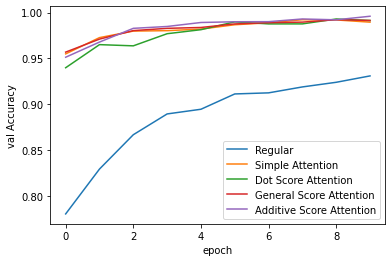

In [33]:
sns.lineplot(x="epoch", y="val Accuracy", data=simple_results, label="Regular")
sns.lineplot(x="epoch", y="val Accuracy", data=simple_attn_results, label="Simple Attention")

sns.lineplot(x="epoch", y="val Accuracy", data=attention_dot_results, label="Dot Score Attention")
sns.lineplot(x="epoch", y="val Accuracy", data=attention_general_results, label="General Score Attention")
sns.lineplot(x="epoch", y="val Accuracy", data=attention_additive_results, label="Additive Score Attention")

Let's do it with only two real changes.

In [34]:
class LargestDigitVariable(Dataset):
  """
  Creates a modified version of a dataset where some variable number of samples are 
  taken, and the true label is the largest label sampled. When used with MNIST the
  labels correspond to their values (e.g., digit "6" has label 6). Each datum will 
  be padded with 0 values if the maximum number of items was not sampled. 
  """
  def __init__(self, dataset, max_sample=6):
    """
    dataset: the dataset to sample from
    max_sample: the number of items from the dataset to sample
    """
    self.dataset = dataset
    self.max_sample = max_sample

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    # NEW: how many items should we select?
    how_many = np.random.randint(1, self.max_sample, size=1)[0]
    # Randomly select n=self.max_sample items from the dataset
    selected = np.random.randint(0, len(self.dataset), size=how_many)

    # Stack the n items of shape (B, *) shape into (B, n, *)
    # NEW: pad with zero values up to the max size
    x_new = torch.stack([
      self.dataset[i][0] for i in selected + [torch.zeros((1, 28, 28)) for i in range(self.max_sample - how_many)]
    ])
    # Label is the maximum label
    y_new = max([self.dataset[i][1] for i in selected])
    # Return (data, label) pair
    return x_new, y_new

Now, let's creates the training and test set loaders.

In [35]:
largest_v_train = LargestDigitVariable(mnist_train)
largest_v_test = LargestDigitVariable(mnist_test)

train_v_loader = DataLoader(largest_train, batch_size=B, shuffle=True)
test_v_loader = DataLoader(largest_test, batch_size=B)

Instead of training a new model, the following code runs through the test set and
makes predictions.

In [36]:
attention_dot = attention_dot.eval()

preds = []
truths = []
with torch.no_grad():
  for inputs, labels in test_v_loader:
    pred = attention_dot(inputs.to(device))
    pred = torch.argmax(pred, dim=1).cpu().numpy()

    preds.extend(pred.ravel())
    truths.extend(labels.numpy().ravel())
print(f"Variable Length Accuracy: {accuracy_score(preds, truths)}")

Variable Length Accuracy: 0.9605


This gives you an idea of how powerful the attention
approach can be. It can often generalize very well to changes in the input data and
sequence length, which is part of what has made attentions very successful.

They have
quickly become a go-to tool for most natural language processing tasks today.